In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt

# LIF model parameters
params = {
    "E_resting": -70.0,   #mV
     "E_ex":     0,   #mV
    "c_m":       10.0,    #nF
    "g_l":     1,         #uS  
    "V_th":      -54.0,   #mV
    "V_reset":   -80.0,    #mV
    "tau_ex" :   10,      #ms
    "delta_g_ex": 0.5  #uS
}


# Simulation parameters
t_start = 0.0    #ms
t_end = 500.0    #ms
dt = 0.1         #ms s
n_steps = int((t_end - t_start) / dt)
time_points = np.linspace(t_start, t_end, n_steps + 1)
current_duration = 300.0   #ms
pulse_start = 100.0        #ms
pulse_end = 400.0          #ms
pre_spike_times = [100.0, 200.0, 230.0, 300.0, 320.0, 400.0, 410.0]



In [16]:
def lif_synaptic_model(cm, gL, EL, Eex, Vth, Vreset, tau_ex, delta_gex, time_points, pre_spike_times, dt):
    voltage = np.zeros(n_steps+1)
    g_ex = np.zeros(n_steps+1)
    I_ex = np.zeros(n_steps+1)


    voltage[0] = EL               #starting V = E 
    g_ex[0] = 0.0

    spike_indices = {
    int(round((t_spike - time_points[0]) / dt))
    for t_spike in pre_spike_times
    if time_points[0] <= t_spike <= time_points[-1]
}
    
    post_spike_time = []
    
    for i in range(n_steps):
        if i in spike_indices:
            g_ex[i] += delta_gex
            
            
        # update voltage and conductance
        driving_force_L = voltage[i] - EL
        driving_force_ex = voltage[i] - Eex
        dV_dt = (-gL * (driving_force_L) - (g_ex[i] * (driving_force_ex))) / cm
        voltage[i+1] = voltage[i] + dV_dt * dt
        
        dg_ex_dt = -g_ex[i] / tau_ex
        g_ex[i+1] = g_ex[i] + dg_ex_dt * dt
        
        if voltage[i+1] >= Vth:
            post_spike_time.append(time_points[i+1])
            voltage[i+1] = Vreset
        
        I_ex[i] = g_ex[i] * (voltage[i] - Eex)
    
    # for the last time point not in the loop
    I_ex[-1] = g_ex[-1] * (voltage[-1] - Eex)

    return time_points, voltage, g_ex, I_ex, post_spike_time

In [17]:
time_points_sim, voltage_sim, g_ex_sim, I_ex_sim, post_spike_time = lif_synaptic_model(params["c_m"], params["g_l"], params["E_resting"], params["E_ex"], params["V_th"], params["V_reset"], params["tau_ex"], params["delta_g_ex"], time_points, pre_spike_times, dt)

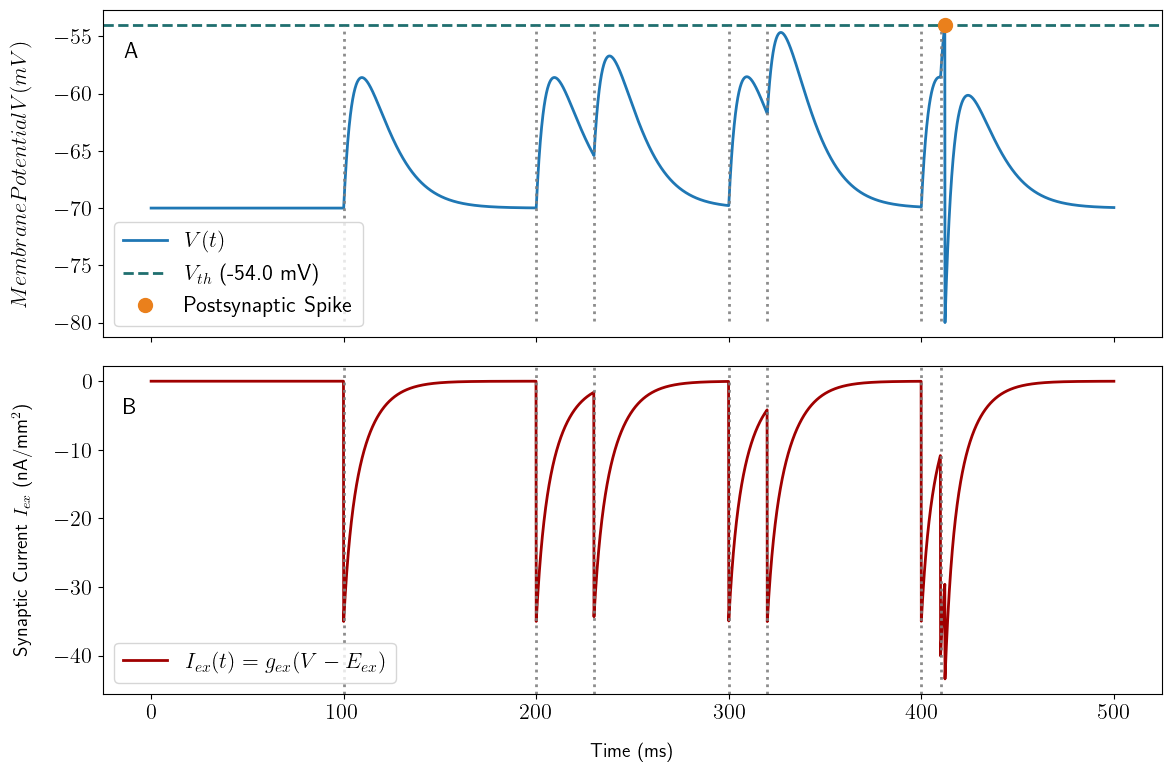

In [74]:
plt.rcParams.update({"font.size":16, "text.usetex":True, "figure.figsize":(12, 8)})
figure, axs = plt.subplots(2, 1, sharex=True)

# Membrane Potential V(t)
axs[0].plot(time_points_sim, voltage_sim, color='C0', linewidth=2, label='$V(t)$')
axs[0].axhline(params["V_th"], color='#1f6f6f', linestyle='--', linewidth=2, label=f'$V_{{th}}$ ({params["V_th"]} mV)')

for t_spike in pre_spike_times:
    axs[0].axvline(t_spike, color='grey', linestyle=':', alpha=0.9, linewidth=2, ymin=0.05, ymax=0.95)

if post_spike_time:
    axs[0].plot(post_spike_time, [params["V_th"]]*len(post_spike_time), 
                 'o',color='#ea801c', markersize=10, label='Postsynaptic Spike')

axs[0].set_ylabel('$Membrane Potential  $$V$$ (mV)$', fontsize='16', labelpad=16)
axs[0].legend(loc='lower left', )
axs[0].text(0.02, 0.90, 'A', transform=axs[0].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


#Synaptic Current I_ex(t)
axs[1].plot(time_points_sim, I_ex_sim, label='$I_{ex}(t) = g_{ex}(V-E_{ex})$', color='#a00000', linewidth=2)

for t_spike in pre_spike_times:
    axs[1].axvline(t_spike, color='grey', linewidth=2, linestyle=':', alpha=0.9) 

axs[1].set_xlabel('Time (ms)', fontsize='14', labelpad=14)
axs[1].set_ylabel('Synaptic Current $I_{ex}$ (nA/mm$^2$)', fontsize='14', labelpad=16)
axs[1].legend(loc='lower left')
axs[1].text(0.02, 0.90, 'B', transform=axs[1].transAxes,
             fontsize=16, fontweight='bold', va='top', ha='left')


plt.tight_layout() 
plt.savefig('1_lif_syn.png', dpi=300)
plt.show()
